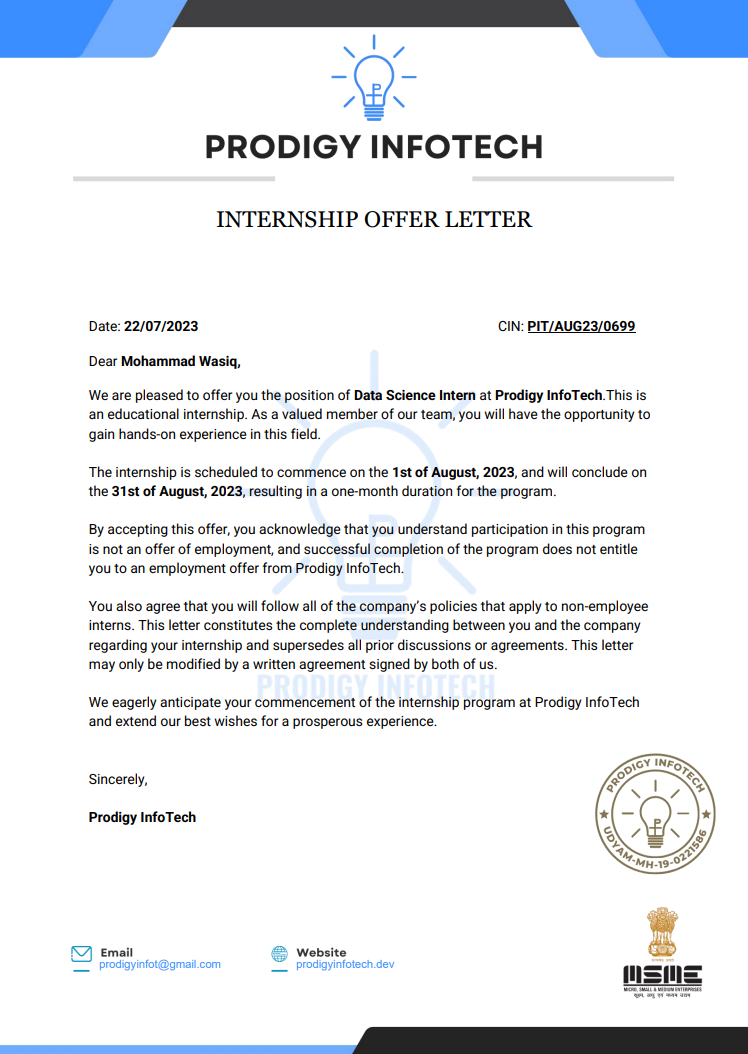

In [2]:
import zipfile
import os

def extract_zip(zip_file_path, output_folder):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_folder)

zip_file_path = '/content/bank-marketing-uci.zip'
output_folder = '/content/Bank Marketing'
extract_zip(zip_file_path, output_folder)


# **Problem Statement**

**The classification goal is to predict if the client will subscribe a term deposit or not**

## Data Information

The data is related with direct marketing campaigns of a Portuguese banking institution.

The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed.

The classification goal is to predict if the client will subscribe a term deposit.


##### Attribute Information

1.  age (numeric)
2.  job : type of job
(categorical: admin", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services")
3.  marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4.  education (categorical: "unknown","secondary","primary","tertiary")
5.  default: has credit in default? (binary: "yes","no")
6.  balance: average yearly balance, in euros (numeric)
7.  housing: has housing loan? (binary: "yes","no")
8.  loan: has personal loan? (binary: "yes","no")
  
**related with the last contact of the current campaign:**

9.  contact: contact communication type (categorical: "unknown","telephone","cellular")
10.  day: last contact day of the month (numeric)
11.  month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12.  duration: last contact duration, in seconds (numeric)
   
**other attributes:**

13.  campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14.  pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15.  previous: number of contacts performed before this campaign and for this client (numeric)
16.  poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

**Output variable (desired target):**

17.  - y - has the client subscribed a term deposit? (binary: "yes","no")

In [1]:
# Import libraries
import os
import json, pickle
import numpy as np

# importing libraries for data structuring and analysis (visualization)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# importing warnings to avoid warnings 
import warnings
warnings.filterwarnings("ignore")

# importing scaler and encoders
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# importing randomised cross validation and train test split (for data seperation)
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Importing Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# importing performance metrixes 
from sklearn.metrics import accuracy_score, precision_recall_curve,classification_report,roc_curve
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score

# to export models and json file for production
import json,pickle

# importing libraries for feature selection
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif, VarianceThreshold
#from skfeature.function.similarity_based import fisher_score

# importing SMOTE to resample data(balancing the data)
from imblearn.over_sampling import SMOTE

# setting to display max columns 
pd.set_option("display.max_columns",None)

In [3]:
data= pd.read_csv("bank.csv",sep=";")
print(data.shape)
data.head(2)

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no


In [4]:
df= data.copy()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [6]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [7]:
df.duplicated().sum()

0

In [8]:
# checking null values (NO null values are found)
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
#  here we can see the data is highly imbalanced
df["y"].value_counts()

no     4000
yes     521
Name: y, dtype: int64

In [10]:
# defining the function to get counts
def get_counts(data):
    plt.figure(figsize = (15,5))
    plt.ylabel("Counts",fontsize = 10)
    return  data.value_counts().plot(kind = "bar",cmap='summer')
    plt.show()

Text(0.5, 0, 'Age')

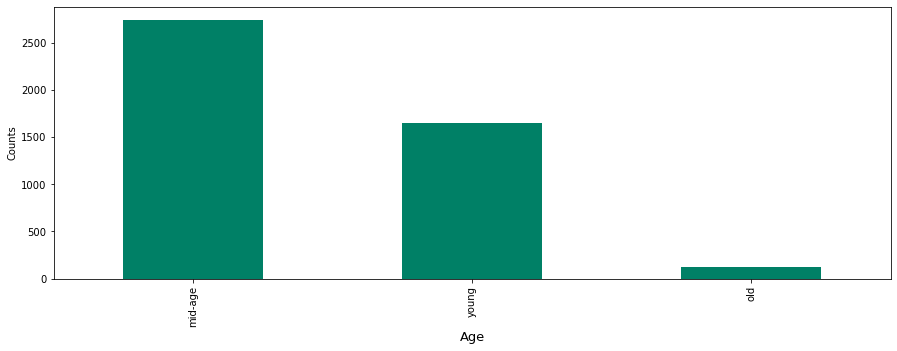

In [11]:
# getting information about counts of the population in each age category.
_ = df["age"]
_ = pd.cut(_,bins = [18,35,60,90],labels = ["young","mid-age","old"])
get_counts(_)
plt.xlabel("Age",fontsize = 13)

Text(0.5, 0, 'Job')

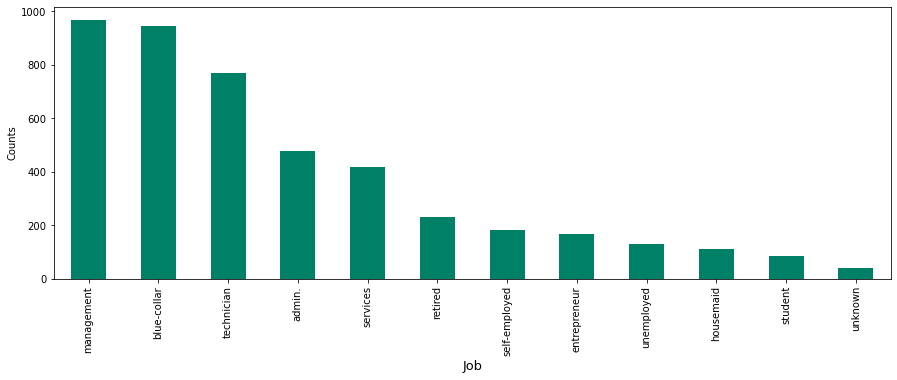

In [12]:
# getting information about counts of the population in each job category.
get_counts(df["job"])
plt.xlabel("Job",fontsize = 13)

Text(0.5, 0, 'Merital Status')

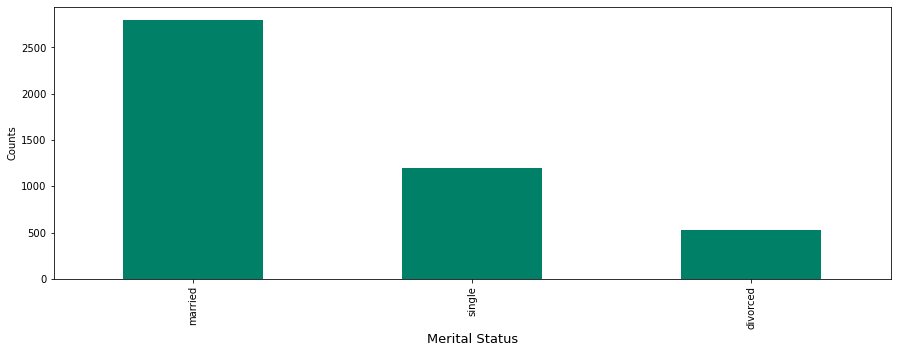

In [13]:
# getting information about counts of the population in each marital category.
get_counts(df["marital"])
plt.xlabel("Merital Status",fontsize = 13)

Text(0.5, 0, 'Education')

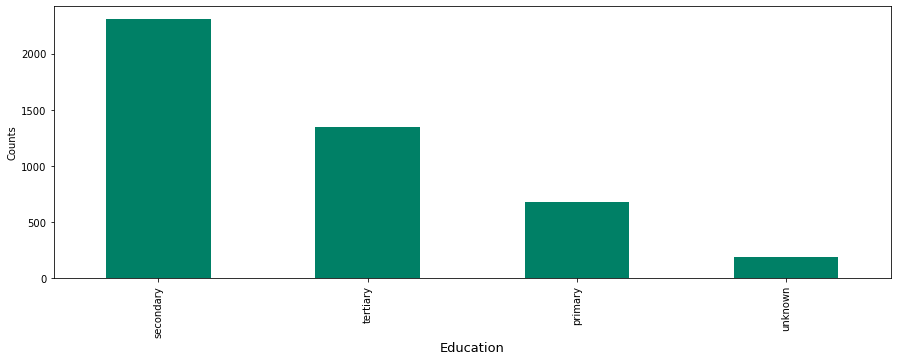

In [14]:
# getting information about counts of the population in each education category.
get_counts(df["education"])
plt.xlabel("Education",fontsize = 13)

Text(0.5, 0, 'Credit in default')

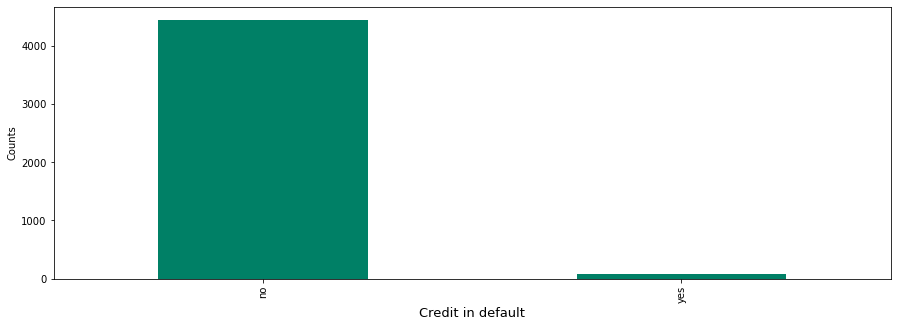

In [15]:
# getting information about counts of the population in each credit category.
get_counts(df["default"])
plt.xlabel("Credit in default",fontsize = 13)

Text(0.5, 0, 'Housing Loan')

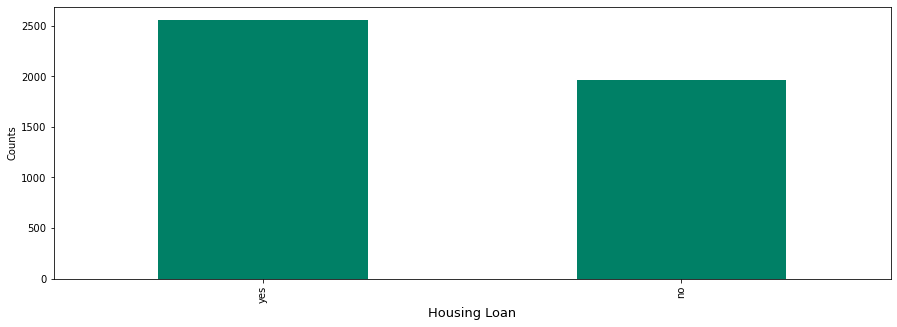

In [16]:
# getting information about counts of the population in each housing loan category.
get_counts(df["housing"])
plt.xlabel("Housing Loan",fontsize = 13)

Text(0.5, 0, 'Personal Loan')

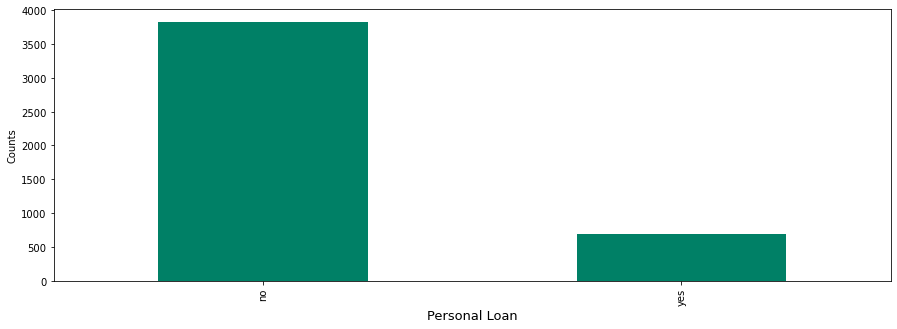

In [17]:
# getting information about counts of the population in each personal loan category.
get_counts(df["loan"])
plt.xlabel("Personal Loan",fontsize = 13)

Text(0.5, 0, 'contact communication type')

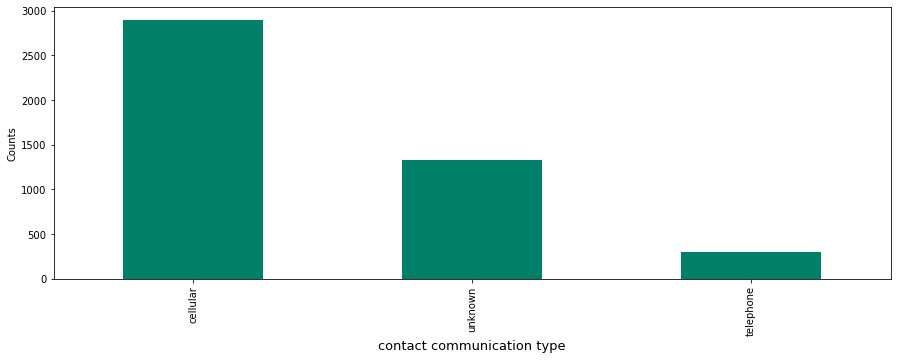

In [18]:
# getting information about counts of the population in each contact communication category.
get_counts(df["contact"])
plt.xlabel("contact communication type",fontsize = 13)

Text(0.5, 0, 'last contact month of year')

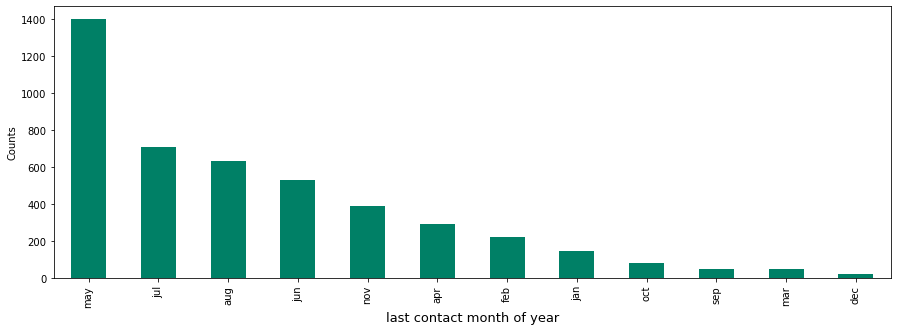

In [19]:
# getting information about counts of the population in each contact last month of year category.
get_counts(df["month"])
plt.xlabel("last contact month of year",fontsize = 13)

Text(0.5, 0, 'Outcome of the previous marketing campaign')

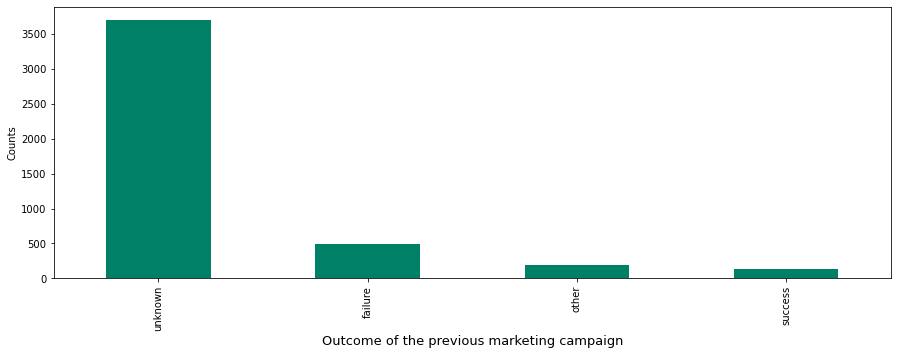

In [20]:
# getting information about counts of the population in each Outcome category.
get_counts(df["poutcome"])
plt.xlabel("Outcome of the previous marketing campaign",fontsize = 13)

In [21]:
# defining a function to get distribution and outliers
def get_distribution(data):
    fig, axes = plt.subplots(1, 2, figsize=(16,4))
    sns.distplot(data, hist = False,ax = axes[0],color="r")
    sns.boxplot(data,ax = axes[1],color="g")
    return plt.show()

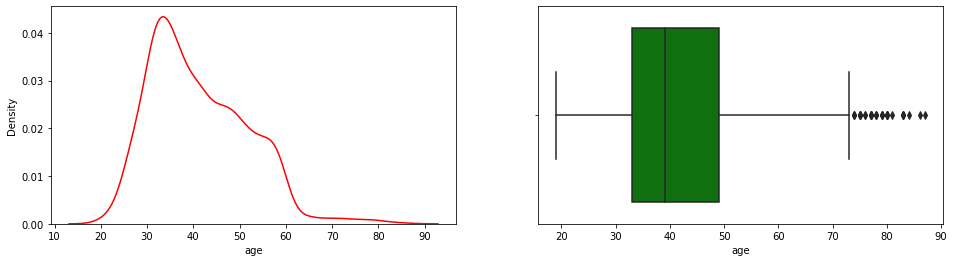

In [22]:
# getting information regarding distribution and outliers of age feature.
get_distribution(df["age"])

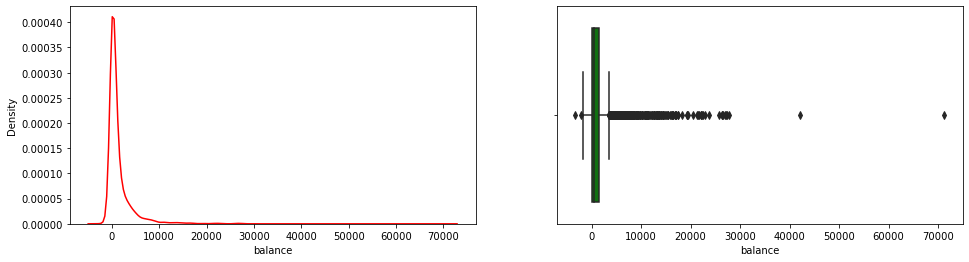

In [23]:
# getting information regarding distribution and outliers of balance feature.
get_distribution(df["balance"])

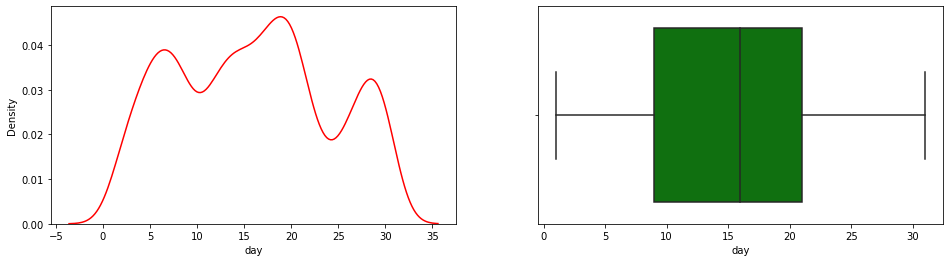

In [24]:
# getting information regarding distribution and outliers of day feature.
get_distribution(df["day"])

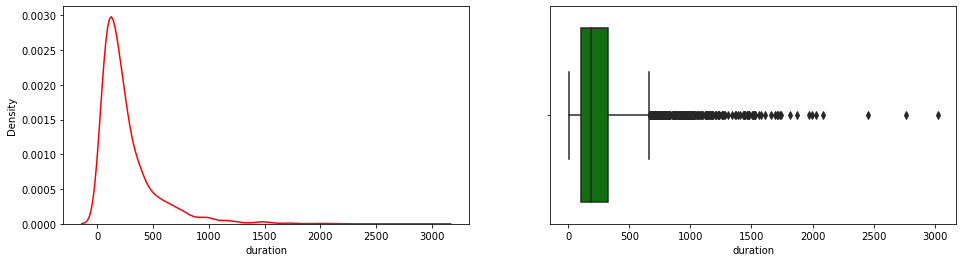

In [25]:
# getting information regarding distribution and outliers of duration feature.
get_distribution(df["duration"])

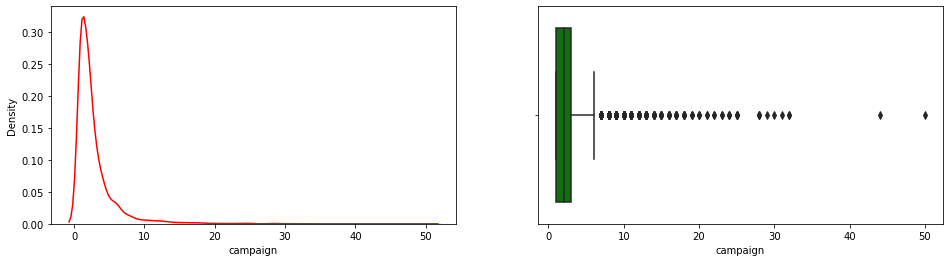

In [26]:
# getting information regarding distribution and outliers of campaign feature.
get_distribution(df["campaign"])

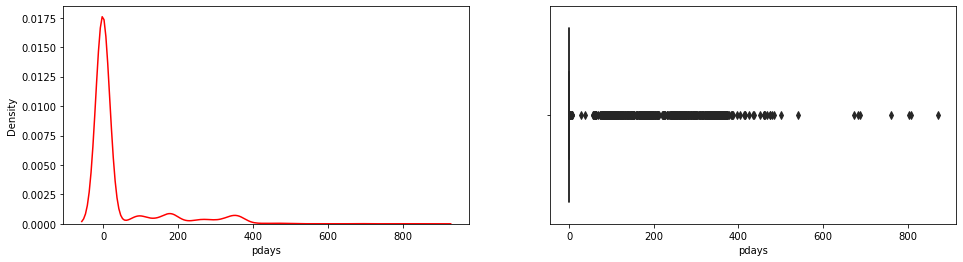

In [27]:
# getting information regarding distribution and outliers of pdays feature.
get_distribution(df["pdays"])

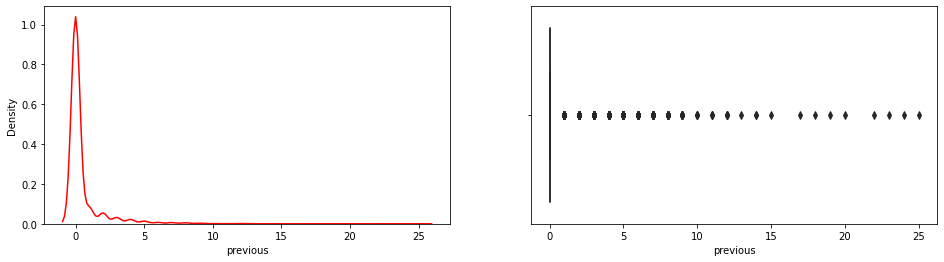

In [28]:
# getting information regarding distribution and outliers of previous feature.
get_distribution(df["previous"])

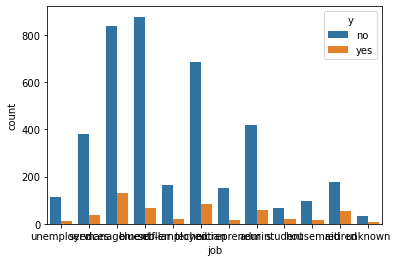

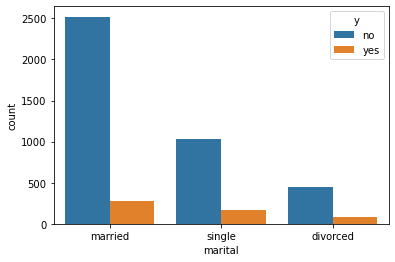

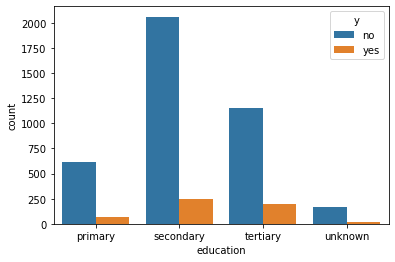

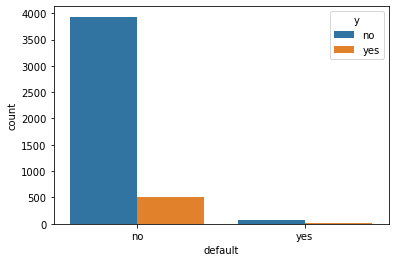

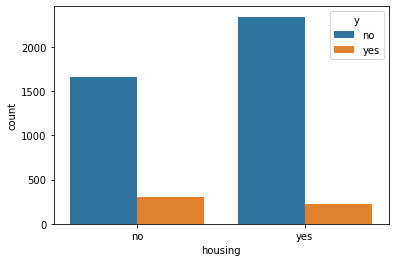

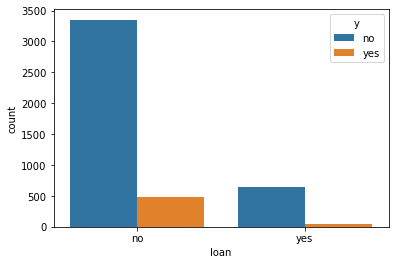

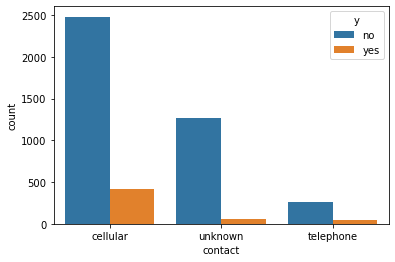

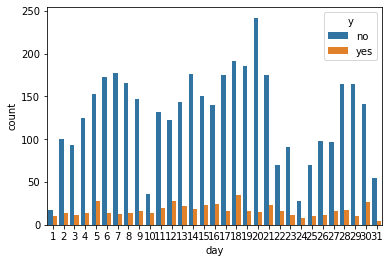

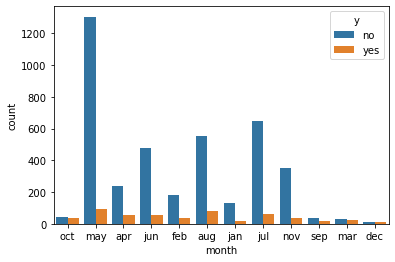

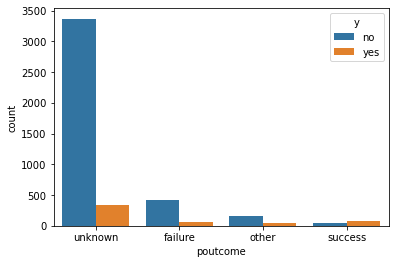

In [30]:
for i,predictor in enumerate(df.drop(columns=['y','age','campaign','previous', 'balance', 'duration','pdays'])):
    plt.figure(i)
    sns.countplot(data=df, x=predictor, hue='y')

## ***Bi & Multi-variate Analysis of the data:***

y
no     40.998000
yes    42.491363
Name: age, dtype: float64


<AxesSubplot:xlabel='y'>

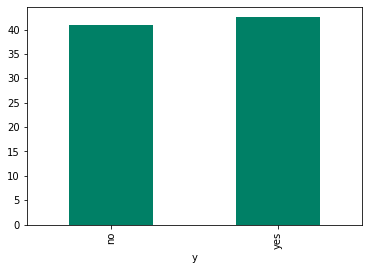

In [31]:
_ = df.groupby("y").mean()["age"]
print(_)
_.plot(kind = "bar", cmap = "summer")

*The average age in each category of target variable is (Yes: 42 years and NO: 40 years)*

In [32]:
df.pivot_table(values = "age", columns = "y",index = "job",aggfunc="mean")

y,no,yes
job,,
admin.,39.471429,41.206897
blue-collar,40.273660,38.666667
entrepreneur,41.993464,42.200000
housemaid,47.571429,45.714286
management,40.763723,39.114504
retired,60.215909,67.259259
self-employed,40.950920,45.550000
services,38.641161,37.868421
student,27.584615,24.210526


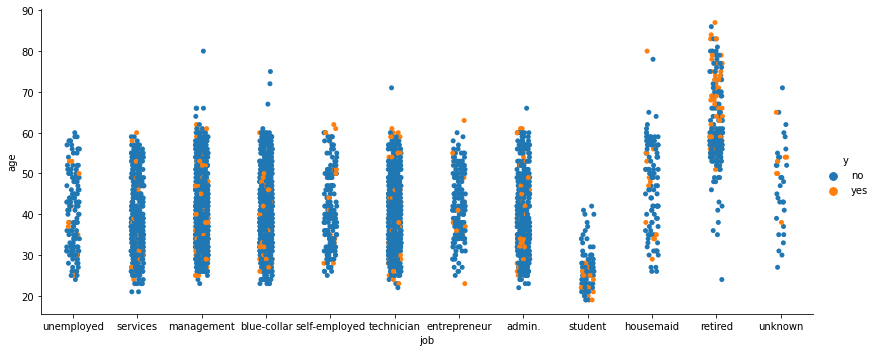

In [33]:
# here is the distribution of ages in each category of job in both of targeted categories.
sns.catplot(data = df, x = "job", y = "age",
            hue = "y", jitter = 0.1, aspect = 2.3,height = 5)

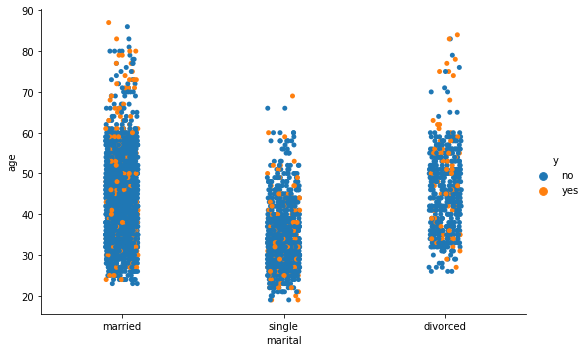

In [34]:
# here is the distribution of ages in each category of marital status in both of targeted categories.
sns.catplot(data = df, x = "marital", y = "age",
            hue = "y", jitter = 0.1, aspect = 1.5,height = 5)

In [35]:
# The average age where housing loan and personal loans are no & no / no & yes / yes & no / Yes & Yes respectively.
df.groupby(["housing","loan"],as_index=False)["age"].mean()

,housing,loan,age
0,no,no,43.470483
1,no,yes,43.754386
2,yes,no,39.468184
3,yes,yes,38.879310


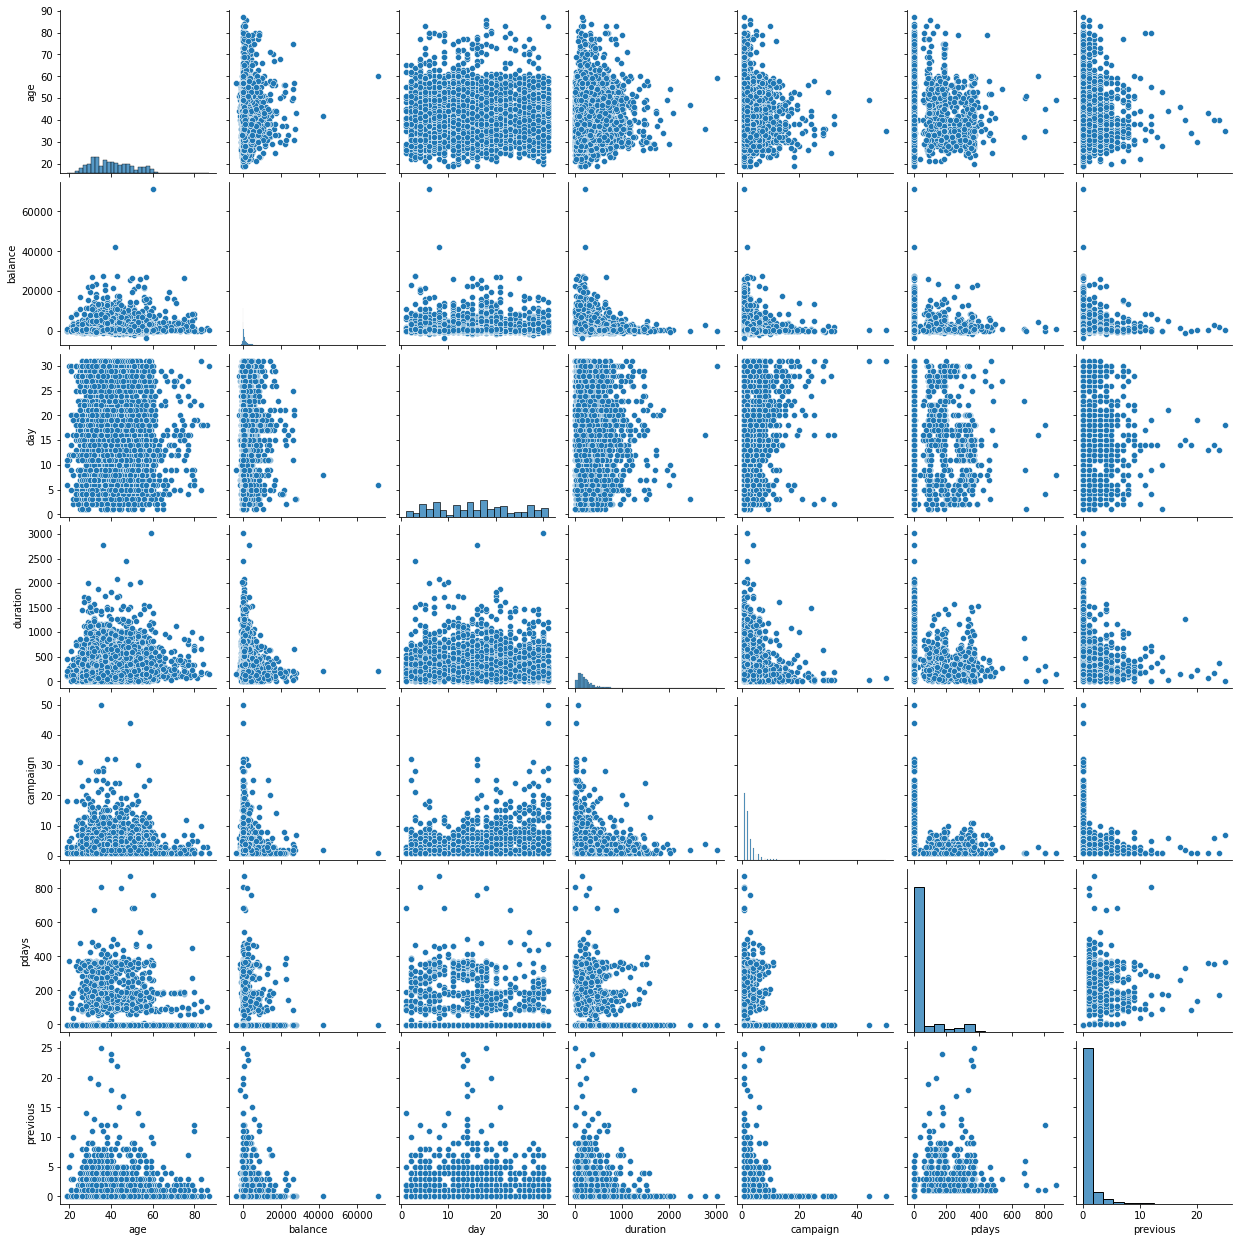

In [36]:
# Getting distribution of data points (checking featuers are related to each other or not)
sns.pairplot(data = df.drop("y",axis = 1))

<AxesSubplot:xlabel='marital,y'>

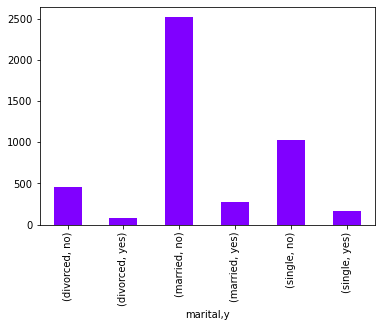

In [37]:
# getting count of categories of marital featuers with categoreis of target features
df.groupby(["marital","y"])["age"].count().plot(kind = "bar",cmap = "rainbow" )

## **Feature Engineering**

In [38]:
# making a copy of data frame
df1 = df.copy()

In [39]:
# as we have seen that days and months features has same information like pdays. So I decided to drop them
df1.drop(["day","month"],axis =1, inplace = True)

In [40]:
# changing unknown with null values (because "unknown" has no information)
for i in df1.columns:
    df1[i] = np.where(df1[i] == "unknown", np.nan, df1[i])
df1.isna().sum()

age             0
job            38
marital         0
education     187
default         0
balance         0
housing         0
loan            0
contact      1324
duration        0
campaign        0
pdays           0
previous        0
poutcome     3705
y               0
dtype: int64

In [41]:
#The percentage of null values in poutcome feature
(3705/df1.poutcome.shape[0])*100

81.95089581950896

In [42]:
#The percentage of null values in contact feature but we can impute the null values of it
(1324/df1.contact.shape[0])*100

29.285556292855563

**As we can see the poutcome has 3705 values null after replacing the unknown with null values. And we will not impute them because the percentage of null values is higher. So, i decided to drop this feature**

In [43]:
# dropping the feature with higher percentage of null values
df1.drop("poutcome", inplace = True, axis = 1)

In [44]:
# We have contact feature with high null values
# Also, there is no effect either they called by cellular or landline. So, i decided to drop it
df1.drop("contact", inplace = True, axis = 1)

In [45]:
# using forward fill method to fill the nan values
df1["job"].fillna(method = "ffill",inplace=True)
df1["education"].fillna(method = "ffill",inplace= True)

In [46]:
# in place of label encoder i am using replace function for ordinal data in independent features
df1["education"].replace({'primary':0, 'secondary':1, 'tertiary':2},inplace = True)
df1["default"].replace({'no':0, 'yes':1},inplace = True)
df1["marital"].replace({'single':0, 'married':1, 'divorced':2},inplace = True)
df1["housing"].replace({'no':0, 'yes':1},inplace = True)
df1["loan"].replace({'no':0, 'yes':1},inplace = True)

In [47]:
# using one hot encoder for nominal data in job feature
ohe = OneHotEncoder()
df1[list(df1["job"].unique())] = ohe.fit_transform(df1[["job"]]).A
df1.drop("job",axis = 1, inplace = True)
df1.head(1)

,age,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,unemployed,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,30.0,1,0,0,1787.0,0,0,79.0,1.0,-1.0,0.0,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
# for target variable I am using the label encoder
label = LabelEncoder()
df1["y"] =  label.fit_transform(df1["y"])
df1.head(1)

,age,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,unemployed,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,30.0,1,0,0,1787.0,0,0,79.0,1.0,-1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Feature Selection

<AxesSubplot:>

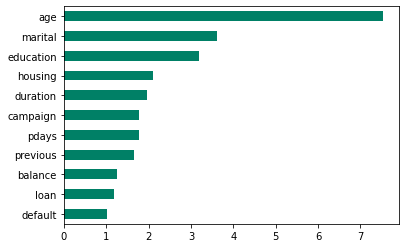

In [49]:
# checking multi co-linearity
_ = df1[['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'duration', 'campaign', 'pdays', 'previous']]
vif_lst = []
for i in range(_.shape[1]):
    vif = variance_inflation_factor(_.to_numpy(),i)
    vif_lst.append(vif)
s1 = pd.Series(vif_lst, index = _.columns)
s1.sort_values().plot(kind = "barh", cmap = "summer")

***As we can see, all the features are independent from each other. Because the VIF values are less than 5(except age). (I am not considering the one hot encoded featues to drop by using (VIF)***

In [54]:
# checking variance threshold
var_th = VarianceThreshold(threshold = 0.0)
var_th.fit_transform(_)
s = pd.Series(var_th.get_support(),index = _.columns)
s

age          True
marital      True
education    True
default      True
balance      True
housing      True
loan         True
duration     True
campaign     True
pdays        True
previous     True
dtype: bool

***It is providing True for all the features, which states that all the features are good predictors.***

In [55]:
# Chi2 test (between categorical features)
_temp = df1[['marital', 'education', 'default', 'housing', 'loan',
        'campaign', 'previous']]
chi, p_val = chi2(_temp,df1["y"])
s = pd.DataFrame({"Chi2":np.around(chi,2), "P_val": np.around(p_val,2)}, index = _temp.columns)
s

,Chi2,P_val
marital,0.43,0.51
education,5.14,0.02
default,0.01,0.93
housing,21.50,0.00
loan,19.05,0.00
campaign,58.50,0.00
previous,325.48,0.00


***Chi2 test stats that marital and default features are not important for the model.***

chi2 is low and p value is high (means variable has no iformation about the target feature)

In [56]:
# taking annova test (continuous vs categorical features)
_temp = df1[['age', 'balance', 'duration', 'pdays']]
f_val,p_val = f_classif(_temp,df1["y"])
pd.DataFrame({"F_Val": np.around(f_val,2), "P_val": np.around(p_val,2)},index = _temp.columns)

,F_Val,P_val
age,9.21,0.00
balance,1.45,0.23
duration,866.51,0.00
pdays,49.50,0.00


***Here we can see the balance featuer is not important***

(f value is low) and (p value is greather than 0.05) means bad predictor

**Dropping the feature**

we have avidance by fisher score and chi2 test that marital is not a good predictor. So I decided to drop it.

In [57]:
df1.drop("marital",inplace = True,axis=1)

## Model Selection

In [58]:
x = df1.drop("y",axis = 1)
y = df1["y"]

In [59]:
# First we have to balance the data for training (I am using SMOTE)
sm = SMOTE(sampling_strategy=0.75)
sm_x,sm_y = sm.fit_resample(x,y)

In [60]:
print(f"First we have the value counts:\n{y.value_counts()}\n\nAfter OverSampling now we have value counts:\n{sm_y.value_counts()}")

First we have the value counts:
0    4000
1     521
Name: y, dtype: int64

After OverSampling now we have value counts:
0    4000
1    3000
Name: y, dtype: int64


In [61]:
# spliting the data for training as well as testing purposes.
x_train,x_test,y_train,y_test = train_test_split(sm_x,sm_y, test_size=0.2, random_state=42, stratify=sm_y)

### Scaling the data

In [62]:
#for scaling I am using standard scaler as It has 0 mean and 1 standard deviation
# To skip Data leakage, we have to train scaler only on training data
std = StandardScaler()
arr = std.fit_transform(x_train)
std_x = pd.DataFrame(arr, columns = x_train.columns)
std_x.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,unemployed,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,-0.808709,-0.125291,-0.110042,-0.240630,1.155964,2.941967,-0.196036,0.127586,-0.481103,-0.420882,3.048284,-0.502707,-0.197454,-0.172877,-0.586078,-0.2978,-0.218043,-0.325968,-0.176085,-0.477472,-0.190884
1,-0.526536,-0.125291,-0.110042,-0.530606,1.155964,-0.339909,-0.977790,-0.233811,3.205012,1.904335,-0.367310,-0.502707,-0.197454,-0.172877,-0.586078,-0.2978,-0.218043,-0.325968,-0.176085,2.375761,-0.190884
2,1.480527,-1.674145,-0.110042,-0.417266,-0.865079,-0.339909,1.330966,1.033663,-0.481103,-0.420882,-0.367310,-0.502707,-0.197454,-0.172877,-0.335129,-0.2978,4.690965,-0.325968,-0.176085,-0.477472,-0.190884
3,-0.051412,-0.125291,-0.110042,-0.147402,-0.865079,-0.339909,-0.563475,-0.085536,0.056464,0.607534,-0.367310,-0.502707,-0.197454,-0.172877,1.209162,-0.2978,-0.218043,0.792934,-0.176085,-0.477472,-0.190884
4,0.541794,-0.125291,-0.110042,-0.307625,-0.865079,-0.339909,2.461437,0.488982,-0.481103,-0.420882,-0.367310,-0.502707,-0.197454,-0.172877,0.566586,-0.2978,2.762180,-0.325968,-0.176085,-0.477472,-0.190884


In [63]:
# Scaling the testing data (we will use pretrained scaler (which we trained on training data))
arr1 = std.transform(x_test)
std_x_te = pd.DataFrame(arr1, columns = x_test.columns)
std_x_te.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,unemployed,services,management,blue-collar,self-employed,technician,entrepreneur,admin.,student,housemaid,retired
0,-0.714651,-0.125291,-0.110042,-0.440155,1.155964,-0.339909,-0.609207,0.127586,-0.481103,-0.420882,-0.367310,-0.502707,-0.197454,-0.172877,1.959852,-0.297800,-0.218043,-0.325968,-0.176085,-0.477472,-0.190884
1,-0.714651,1.423563,-0.110042,-0.551509,1.155964,-0.339909,-0.454639,-0.233811,-0.481103,-0.420882,-0.367310,-0.502707,-0.197454,-0.172877,1.959852,-0.297800,-0.218043,-0.325968,-0.176085,-0.477472,-0.190884
2,0.712180,-0.125291,-0.110042,0.068908,-0.865079,-0.339909,1.447203,-0.595207,-0.481103,-0.420882,-0.367310,-0.502707,-0.197454,-0.172877,-0.586078,1.762619,-0.218043,-0.325968,-0.176085,1.034805,-0.190884
3,-0.706127,-1.674145,-0.110042,-0.647882,-0.865079,-0.339909,0.825911,-0.595207,-0.481103,-0.420882,2.893507,-0.380201,-0.197454,-0.172877,-0.586078,-0.297800,-0.218043,-0.325968,-0.176085,-0.477472,-0.190884
4,-0.808709,-0.125291,-0.110042,0.420272,1.155964,-0.339909,-0.537868,-0.595207,-0.481103,-0.420882,3.048284,-0.502707,-0.197454,-0.172877,-0.586078,-0.297800,-0.218043,-0.325968,-0.176085,-0.477472,-0.190884


In [64]:
lst = [("LogisticRegression",LogisticRegression()),
       ("KNN Classifier", KNeighborsClassifier()),
       ("RandomForest",RandomForestClassifier()),
      ("AdaBoost",AdaBoostClassifier()),
      ("XGBoost",XGBClassifier())]
for name,model in lst:
    model.fit(std_x,y_train)
    y1 = model.predict(std_x)
    accuracy = accuracy_score(y_train,y1)
    y2 = model.predict(std_x_te)
    acc_te = accuracy_score(y_test,y2)
    print(f"For {name}::\nThe Training Accuracy is: {accuracy}\nThe Testing Accuracy is: {acc_te}")
    print("--"*40)

For LogisticRegression::
The Training Accuracy is: 0.8271428571428572
The Testing Accuracy is: 0.8228571428571428
--------------------------------------------------------------------------------
For KNN Classifier::
The Training Accuracy is: 0.9196428571428571
The Testing Accuracy is: 0.8771428571428571
--------------------------------------------------------------------------------
For RandomForest::
The Training Accuracy is: 1.0
The Testing Accuracy is: 0.9235714285714286
--------------------------------------------------------------------------------
For AdaBoost::
The Training Accuracy is: 0.9139285714285714
The Testing Accuracy is: 0.8964285714285715
--------------------------------------------------------------------------------
For XGBoost::
The Training Accuracy is: 0.99375
The Testing Accuracy is: 0.9271428571428572
--------------------------------------------------------------------------------


 ***As we can see that, we are getting good accuracy in xgboost model. So, we will move forward with xgbclassifier model.***

## Tuning the Model

In [65]:
estimator = XGBClassifier()
parameters = {"n_estimators": [50,100,150,200,250,300,350,400],
             "max_depth": np.arange(2,10),
             "learning_rate": np.arange(0.01,0.1,0.02),
             'subsample': np.arange(0.5, 1.0, 0.1),
             'colsample_bytree': np.arange(0.4, 1.0, 0.1),
             'colsample_bylevel': np.arange(0.4, 1.0, 0.1)}
rscv = RandomizedSearchCV(estimator, parameters, cv = 5, random_state= 42)
rscv.fit(std_x,y_train)
rscv.best_params_

{'subsample': 0.7,
 'n_estimators': 150,
 'max_depth': 8,
 'learning_rate': 0.08999999999999998,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.7999999999999999}

In [66]:
xgb = XGBClassifier(subsample = 0.7, n_estimators = 150,
                    max_depth = 8, learning_rate = 0.09,
                    colsample_bytree = 0.7, colsample_bylevel = 0.8)
xgb.fit(std_x,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.09, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
# checking the performance of the model at Training time
y_pr_train = xgb.predict(std_x)
acc_train = accuracy_score(y_train,y_pr_train)
class_re = classification_report(y_train,y_pr_train)
con_mat = confusion_matrix(y_train,y_pr_train)
print("Confusion Matrix:\n",con_mat)
print("\n")
print("The accuracy of the model:",(acc_train)*100)
print("\n")
print("The classification report:\n",class_re)

In [ ]:
# checking the performance of the model at Testing time
y_pr_test = xgb.predict(std_x_te)
acc_test = accuracy_score(y_test,y_pr_test)
class_re1 = classification_report(y_test,y_pr_test)
con_mat1 = confusion_matrix(y_test,y_pr_test)
print("Confusion Matrix:\n",con_mat1)
print("\n")
print("The accuracy of the model:",(acc_test)*100)
print("\n")
print("The classification report:\n",class_re1)

In [ ]:
# Now checking the importances of the featues
s = pd.Series(xgb.feature_importances_,sm_x.columns)
s.sort_values().plot(kind = "barh",cmap = "summer")

In [ ]:
# Ploting the Roc - Auc Curve on Testing data
y_prob = xgb.predict_proba(std_x_te)
y_pr   = y_prob[:,1]
auc_score = roc_auc_score(y_test, y_pr)
fpr,tpr,threshold = roc_curve(y_test,y_pr)
plt.plot(fpr,tpr, "r")
plt.text(1, 0.02, 'AUC = %0.3f' % auc_score, ha='right', fontsize=12,weight='bold', color='green')
plt.fill_between(fpr, tpr, facecolor='orange', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - AUC CURVE")
plt.show()

In [ ]:
with open("Standerd_scaling.pkl", "wb") as f:
    pickle.dump(std, f)
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

## Neural Network

#### Objective
> 1. Create a basic Artificial Neural network
> 2. Train the network to fit and understand the Data
> 3. Predict on validation data to check its performance

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [ ]:
nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(30, activation='relu', input_shape=(14,)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
nn_model.summary()

In [ ]:
history=nn_model.fit(X_train,y_train,epochs=100,validation_split=0.2,verbose=0)

In [ ]:
y_pred=nn_model.predict(X_valid)

In [ ]:
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
print(classification_report(y_valid, y_pred))

### Hyperparameter Optimization

In [ ]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(14,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    X_train, y_train, epochs=epochs, validation_split=0.2, verbose=0
  )

  return nn_model, history

In [ ]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32, 64]:
  for dropout_prob in[0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}")
        model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, epochs)
        plot_history(history)
        val_loss = model.evaluate(X_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

In [ ]:
y_pred = least_loss_model.predict(X_valid)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)

In [ ]:
print(classification_report(y_valid, y_pred))

In [ ]:
least_loss_model.summary()

In [ ]:
least_loss_model.get_config()

## Conclusion
* ##### As you can see through hyperparameter optimization the best model that we obtain has an overal accuracy of 78% which is better than most traditional algorithms. The accuracy can futher be improved by increasing the number of epochs <br><br> All the models are bottlenecked by the Dataset as the original dataset was very skewed <br>

### Scope of Future Improvements
> .1 A much Larger Dataset should be generated and used<br>
> .2 Dataset should be balanced<br>
> .3 Data Tranformation methods can be used to tranform data based on their correlations<br>
> .4 Hyperparameter Optimization can be done using diffrent activation funtions, No. of epochs and No. of layes to obtain the most optimal model